**Access Across America (AAA)** from [**Accessibility Observatory**](https://ao.umn.edu/) at the University of Minnesota

* **[Available datasets](https://ao.umn.edu/data/datasets)**
* **[Methodology report for transit access](https://ao.umn.edu/research/america/transit/2019/documents/AccessAcrossAmerica-Transit2019-Methodology.pdf)**
* **[Transit data documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

# 1. Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from mobilkit.umni import *
from project import *

In [3]:
import fiona

In [4]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/03 20:01:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/03 20:01:04 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


# 2. Prepare data

## 2.1. Download

**[DRIVE (2018)](https://conservancy.umn.edu/handle/11299/211408)**

Data not available for Indiana 😭

**[TRANSIT (2019)](https://conservancy.umn.edu/handle/11299/218072)**

In [5]:
# %%bash
# dir='../data/aaa/transit'
# mkdir -p $dir; cd $dir
# fname='IN_transit_accessibility_data_2019_geopackage.zip?sequence=68'
# wget https://conservancy.umn.edu/bitstream/handle/11299/218072/$fname&isAllowed=y
# unzip $fname
# rm $fname *.pdf *.txt
# mv IN_tr_2019_0700-0859-avg.gpkg indiana.gpkg

**[BIKE (2019)](https://conservancy.umn.edu/handle/11299/218194)**

In [6]:
# %%bash
# dir='../data/aaa/bike'
# mkdir -p $dir; cd $dir
# fname='IN_bike_accessibility_data_2019.zip?sequence=70'
# wget https://conservancy.umn.edu/bitstream/handle/11299/218194/$fname/&isAllowed=y
# unzip "$fname%2F"
# unzip IN_bike_accessibility_data_2019_lts4.zip
# rm $fname *.zip *.pdf *.txt
# mv IN_bi_2019_1200_lts4.gpkg indiana.gpkg

**[WALK (2014)](https://conservancy.umn.edu/handle/11299/173991)**

Only available for Indianapolis region

In [7]:
# %%bash
# dir='../data/aaa/walk'
# dir='aaa/walk'
# mkdir -p $dir; cd $dir
# fname='26900_wa_2014_0700-0700.zip?sequence=38&isAllowed=y'
# wget "https://conservancy.umn.edu/bitstream/handle/11299/173991/$fname"
# unzip $fname
# rm $fname

## 2.2. Extract layers

In [8]:
def extract_aaa_layers(mode: str):
    mode = mode.lower()
    geom_file = Path(f'../data/aaa/{mode}/indiana.gpkg')
    if not geom_file.exists(): return
    for layer in tqdm(fiona.listlayers(geom_file)):
        if not layer.startswith(mode[:2]): continue
        max_tt = int(layer.split('_')[1])
        df = gpd.read_file(geom_file, layer=layer,
                           ignore_geometry=True, engine='pyogrio')
        df = df.drop(columns='id').rename(columns={'blockid': 'geoid'})
        df.to_parquet(f'../data/aaa/{mode}/{max_tt:02}.parquet')
    geom_file.unlink()

In [9]:
extract_aaa_layers('BIKE') # t=3:44

In [10]:
extract_aaa_layers('TRANSIT') # t=3:38

## 2.3. Filter relevant data
- **[Columns documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

- **[Description of LODES columns](https://lehd.ces.census.gov/data/lodes/LODES7/LODESTechDoc7.4.pdf)**

- Chosen variables described in a file: `../data/aaa/lehd_vars.yaml`.

In [11]:
# import yaml

# with open('../data/aaa/lehd_vars.yaml', 'rb') as f:
#     lehd_vars = yaml.safe_load(f)
# lehd_var_codes = Arr(sum([list(x.keys()) for x in lehd_vars.values()], []))
# lehd_var_codes

In [12]:
lodes_cols = {
    'c000': 'total', # Total number of jobs
    ## Worker age
    'ca01': 'age_low', # Number of jobs of workers age 29 or younger
    'ca02': 'age_mid', # Number of jobs for workers age 30 to 54
    'ca03': 'age_high', # Number of jobs for workers age 55 or older
    ## Job earnings
    'ce01': 'salary_low', # Number of jobs with earnings $1250/month or less
    'ce02': 'salary_mid', # Number of jobs with earnings $1251/month to $3333/month
    'ce03': 'salary_high', # Number of jobs with earnings greater than $3333/month
}

In [13]:
def get_aaa(scales=SCALES, modes=('BIKE', 'TRANSIT'), max_tts=MAX_TT,
            cols=lodes_cols, year=2017, overwrite=False):
    outfile = Path('../data/aaa/aaa.parquet')
    if outfile.exists() and not overwrite:
        return pd.read_parquet(outfile)
    # define the columns of interest based on LEHD columns
    # for AAA, include both residential area characteristics (RAC)
    # and work area characteristics (WAC)
    cols_list = sum([[f'{k}_{x}_{year % 2000}' for x in cols.keys()]
                     for k in ['r', 'w']], [])
    res = []
    for mode in modes:
        for tmax in max_tts:
            # read the processed file for this mode & max travel time
            file = f'../data/aaa/{mode.lower()}/{tmax:02}.parquet'
            # filter only the relevant columns
            df = pd.read_parquet(file).set_index('geoid')[cols_list]
            # remove the year suffix from the column names
            df = df.rename(columns=lambda x: x[:-3]).reset_index()
            for scale in scales:
                # compute the geoid of the zones at required scale
                nchar = {'BG': 12, 'TRACT': 11, 'COUNTY': 5}[scale]
                d = df.assign(geoid=df.geoid.str[:nchar])
                # compute mean job count accessible from all blocks
                d = d.groupby('geoid').mean().reset_index()
                # convert to long format
                d = d.melt('geoid', var_name='category', value_name='njobs')
                d['is_rac'] = d['category'].str.startswith('r')
                d['category'] = d['category'].str[2:].map(cols).str.upper()
                d.insert(0, 'scale', scale)
                d.insert(1, 'mode', mode)
                d.insert(2, 'tmax', str(tmax))
                res.append(d)
    # concatenate the tables and convert categorical vars to save space
    cat_cols = ('scale', 'mode', 'tmax', 'geoid', 'category')
    res = (pd.concat(res).reset_index(drop=True)
           .astype({x: CAT for x in cat_cols}))
    res.to_parquet(U.mkfile(outfile))
    return res

aaa = get_aaa(overwrite=0).disp() # t=0:06

718,032 rows x 7 cols; Memory: 10.9 MiB


,scale,mode,tmax,geoid,category,njobs,is_rac
,<category>,<category>,<category>,<category>,<category>,<float64>,<bool>
0,COUNTY,BIKE,15,18001,TOTAL,1186.442203,True


# 3. Visualize

In [14]:
zones = gpd.read_parquet('../data/zones/zones_2010.parquet').to_crs(CRS_M).disp()

6,417 rows x 6 cols; Memory: 1.4 MiB; CRS: EPSG:3857


,geoid,name,aland,awater,geometry,scale
,<object>,<object>,<int64>,<int64>,<geometry>,<object>
0,18083,Knox,1336514262,20755159,"POLYGON ((-9741147.962964 4683574.018353, -974...",COUNTY


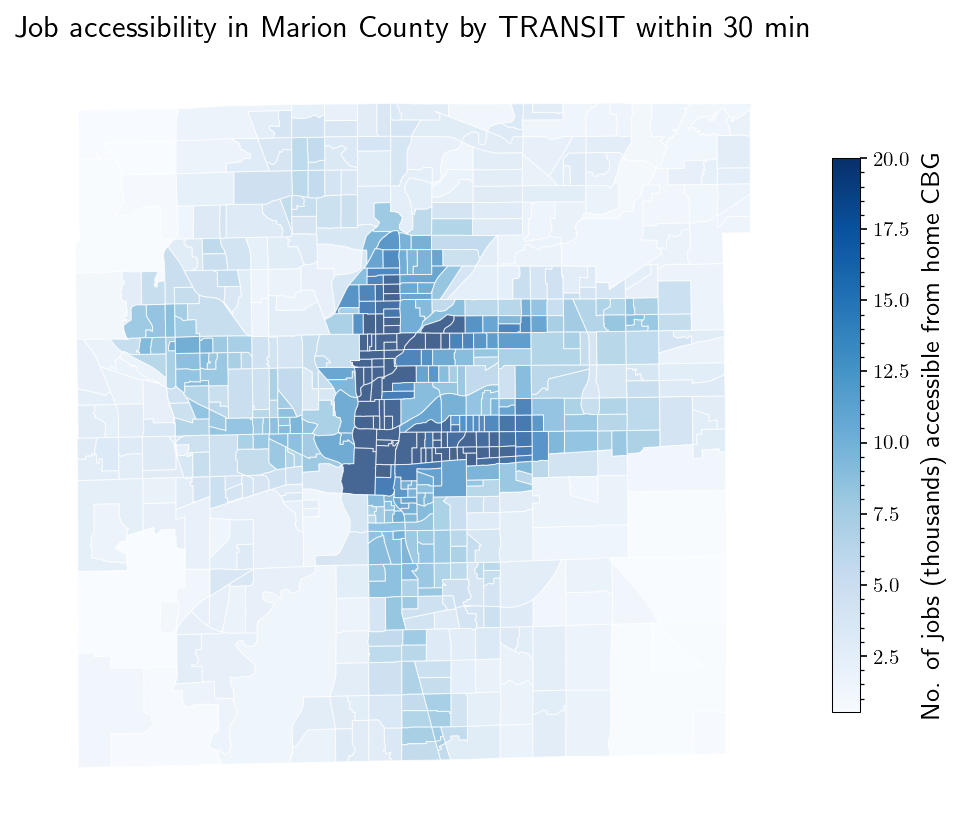

In [16]:
df = aaa.query("scale=='BG' & mode=='TRANSIT' & tmax=='30' & category=='TOTAL' & is_rac")
marion_fips = zones.query('scale=="COUNTY" & name=="Marion"').iloc[0].geoid
df = df[df.geoid.str.startswith(marion_fips)]
df = zones.merge(df, on='geoid').assign(njobs=lambda df: df.njobs / 1000)
title = 'Job accessibility in Marion County by TRANSIT within 30 min'
ax = U.plot(size=(8, 8), axoff=1, title=title)
label = 'No. of jobs (thousands) accessible from home CBG'
df.plot(ax=ax, column='njobs', alpha=0.75, edgecolor='w', lw=0.5,
        cmap='Blues', vmax=20, legend=True, legend_kwds=D(
            shrink=0.6, label=label));
# ctx.add_basemap(ax=ax, crs=CRS_M);

In [17]:
df = aaa.query("scale=='TRACT' & mode=='TRANSIT' & tmax=='60' & is_rac")
df = df[df['category'].str.startswith('SALARY')]
df = df.merge(df.groupby('geoid')['njobs'].sum().rename('tot_jobs'), on='geoid')
df['ratio'] = df.njobs / df.tot_jobs
df.category = df.category.str.replace('SALARY_', '').str.title()
df = zones.merge(df, on='geoid')[['category', 'njobs', 'ratio', 'geometry']].disp()

4,524 rows x 4 cols; Memory: 0.4 MiB; CRS: EPSG:3857


,category,njobs,ratio,geometry
,<object>,<float64>,<float64>,<geometry>
0,Low,79.097826,0.267438,"POLYGON ((-9614898.747343 4754927.664535, -961..."


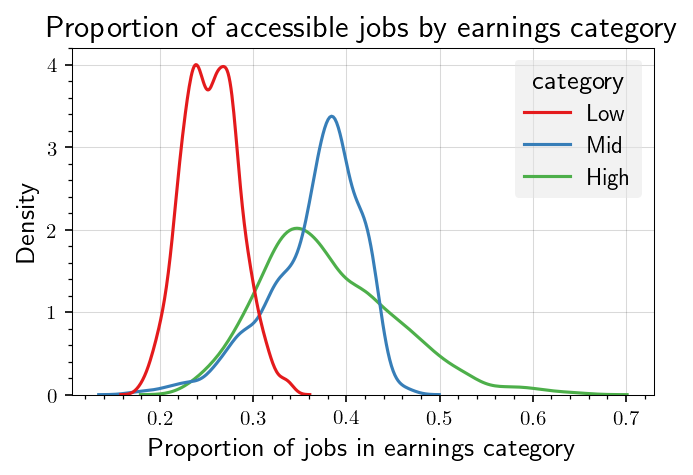

In [17]:
ax = U.plot(size=(5, 3))
sns.kdeplot(df, ax=ax, x='ratio', hue='category', palette='Set1')
ax = U.plot(ax, xlab='Proportion of jobs in earnings category', ylab='Density',
            title='Proportion of accessible jobs by earnings category')

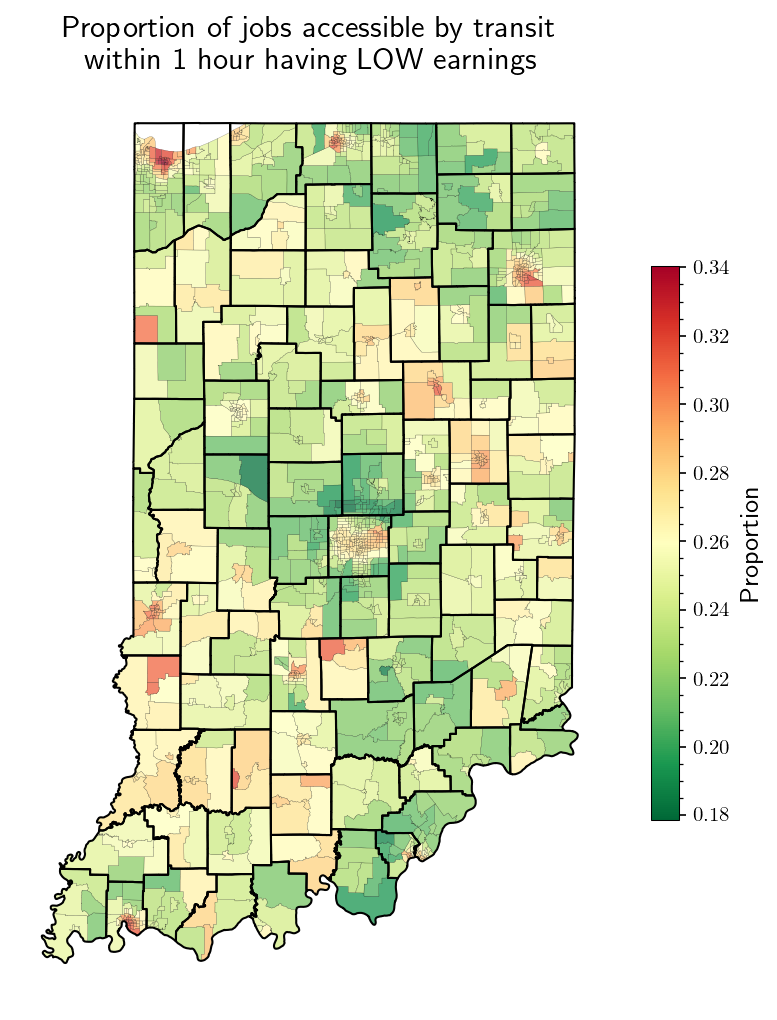

In [18]:
title = 'Proportion of jobs accessible by transit\nwithin 1 hour having LOW earnings'
ax = U.plot(size=(8, 8), axoff=1, title=title)
df[df.category == 'Low'].plot(
    ax=ax, column='ratio', alpha=0.75, ec='k', lw=0.1, cmap='RdYlGn_r', legend=True,
        legend_kwds=D(shrink=0.6, label='Proportion'))
zones.query('scale=="COUNTY"').plot(ax=ax, fc='none', ec='k', lw=1);

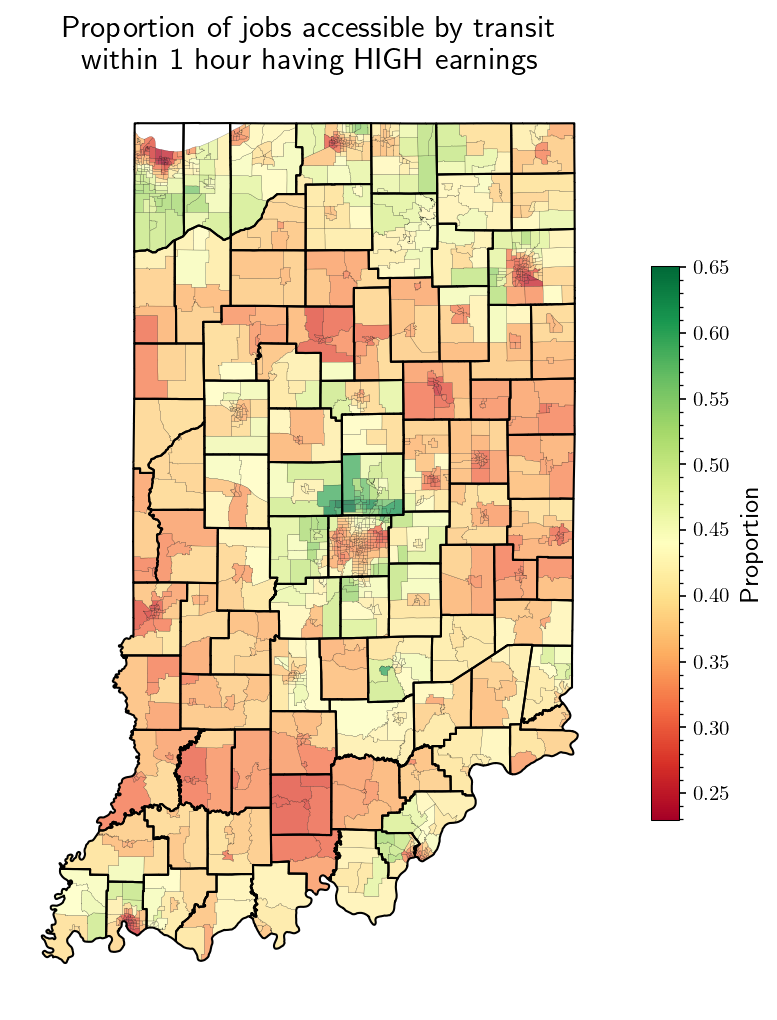

In [19]:
title = 'Proportion of jobs accessible by transit\nwithin 1 hour having HIGH earnings'
ax = U.plot(size=(8, 8), axoff=1, title=title)
df[df.category == 'High'].plot(
    ax=ax, column='ratio', alpha=0.75, ec='k', lw=0.1, cmap='RdYlGn', legend=True,
        legend_kwds=D(shrink=0.6, label='Proportion'))
zones.query('scale=="COUNTY"').plot(ax=ax, fc='none', ec='k', lw=1);